# Módulos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML, Audio, clear_output, display, display_html
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from random import random, choice, randint

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchaudio import transforms

import pathlib, os
from tqdm import tqdm

sns.set()

import warnings
warnings.filterwarnings('ignore')

# Arquivos

In [2]:
sound_list = [str(l) for l in list(pathlib.Path('./data').glob('*/*')) if str(l).endswith('.wav')]
print (f'{len(sound_list)}')

30000


# Análise de alguns áudios

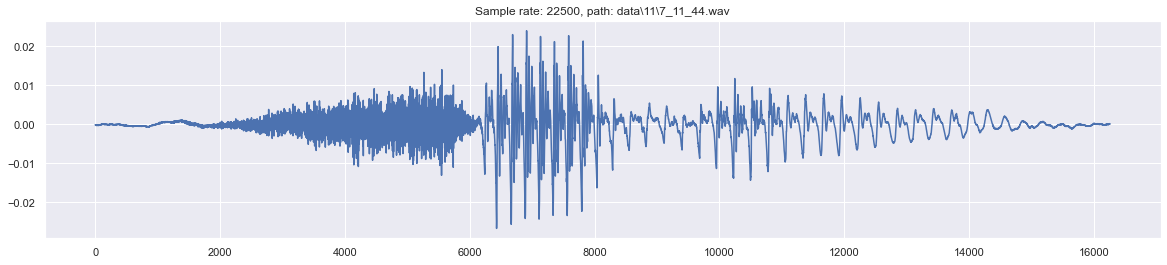

In [3]:
SR = 22_500
sound_path = choice(sound_list)
data_array, sr = torchaudio.load(sound_path)
resampler = transforms.Resample(orig_freq=sr, new_freq=SR)
data_array = resampler(data_array)

plt.figure(figsize=(20, 4))
plt.title(f'Sample rate: {SR}, path: {sound_path}')
plt.plot(data_array.reshape(-1).detach().numpy())
plt.show()

# Mel Spectograma

melspec.shape: torch.Size([1, 128, 32])


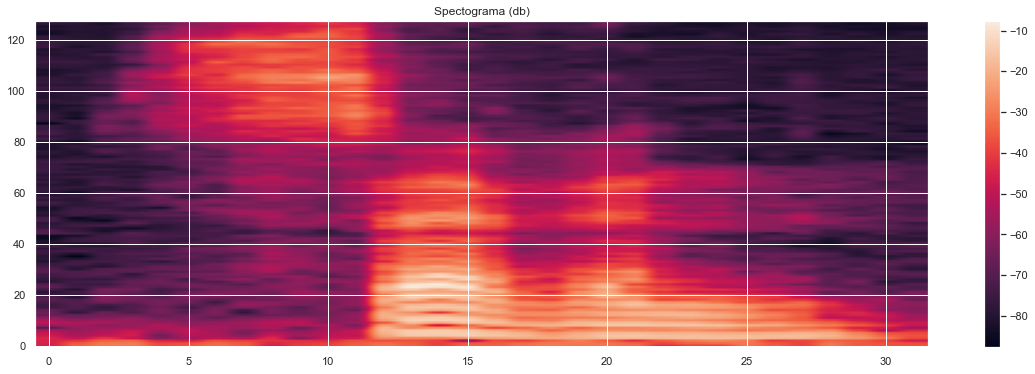

In [4]:
mel_transform = transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft = 1024,
    win_length=None,
    hop_length=512,
    n_mels=128,
    center=True,
    pad_mode='reflect',
    power=2.0,
    norm='slaney',
    onesided=True,
    mel_scale='htk'
)

melspec = mel_transform(data_array)
print (f'melspec.shape: {melspec.shape}')
img = librosa.power_to_db(melspec)
img = np.squeeze(img)
plt.figure(figsize=(20, 6))
plt.title('Spectograma (db)')
plt.imshow(img, origin='lower', aspect='auto')
plt.colorbar()
plt.show()

# Extração de features MFCC
- O que representa graficamente o MFCC

torch.Size([40, 151])


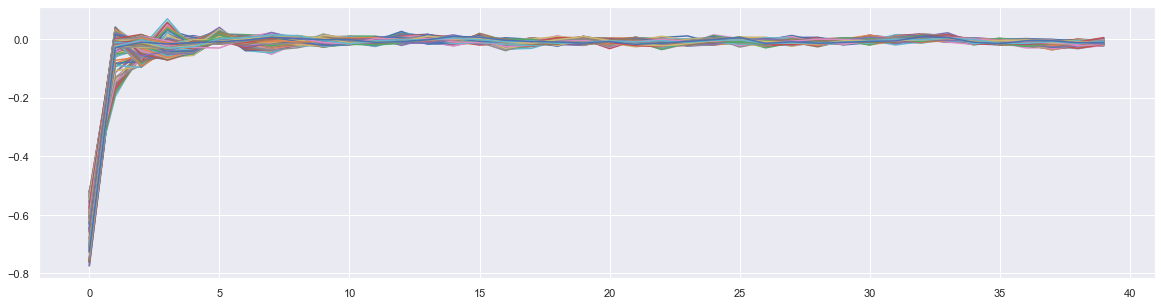

In [5]:
transformer = transforms.MFCC(sample_rate=48_000, n_mfcc=40)
sound_data, sr_ = torchaudio.load(choice(sound_list))
soundf = transformer(sound_data) / 1000
soundf.squeeze_()
print (soundf.shape)

plt.figure(figsize=(20, 5))
for valores in torch.transpose(soundf, 0, 1):
    plt.plot(valores)
plt.show()

# Criando um dataset e dataloader

In [6]:
class custom_dataset(Dataset):

    def __init__(self, df_, n_mfcc):
        self.df = df_
        self.n_mfcc = n_mfcc
        self.transformer = transforms.MFCC(sample_rate=48_000, n_mfcc=self.n_mfcc)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        sound_path = self.df[index]
        classe = int(sound_path.split('\\')[-1].split('_')[0])
        data_array, sr_ = torchaudio.load(sound_path)
        return self.transformer(data_array).mean(dim=-1) / 1_000, torch.tensor(classe)

dataset = custom_dataset(sound_list, 40)

# soundf, classe_ = choice(dataset)
# print (f'shape: {soundf.shape}, min: {soundf.min()}, max: {soundf.max()}, classe: {classe_}')

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
sound_batch = next(iter(dataloader))
sound_batch

[tensor([[[-6.0196e-01, -5.3026e-02, -5.5336e-02,  1.9106e-02, -2.6835e-03,
            7.9088e-03,  3.7872e-03, -6.8721e-03, -2.0502e-02, -5.2080e-03,
           -6.1827e-03,  7.7446e-03, -6.9519e-03, -2.3697e-03, -1.0423e-02,
           -5.6857e-03, -2.6097e-03, -2.7221e-03, -8.2397e-03, -1.5575e-03,
           -6.0542e-03, -1.2056e-02, -7.8307e-03, -5.9501e-03, -4.5881e-03,
           -5.9649e-03, -9.8456e-03, -3.7720e-03, -4.1398e-03, -5.0909e-03,
           -5.0208e-03,  5.8738e-04, -2.1432e-04, -2.6707e-03, -3.4972e-03,
           -7.0155e-03, -1.1347e-02, -9.2450e-03, -1.2404e-02, -7.9646e-03]]]),
 tensor([6])]

# Rede Neural

In [7]:
class custom_model(nn.Module):

    def __init__(self, n_mfcc, n_classes):
        super(custom_model, self).__init__()
        self.n_classes = n_classes
        self.n_mfcc = n_mfcc
        backbone = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )
        input_ex = torch.rand((1, 1, self.n_mfcc))
        output = backbone(input_ex)
        backbone_out = output.shape[-1]

        self.net = nn.Sequential(
            backbone,
            nn.Linear(in_features=backbone_out, out_features=256),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=self.n_classes)
        )
    
    def forward(self, x):
        return self.net(x)

model = custom_model(n_mfcc=40, n_classes=10)
input_batch, target_batch = next(iter(dataloader))
output = model(input_batch)
output.shape

torch.Size([1, 10])

# Função Validação

In [8]:
def validar(model_, loss_fn_, dataloader_, device_):
    model_.eval()
    with torch.no_grad():
        test_loss, total_itens = 0, 0
        ypreds, ytrues = [], []
        for x, y in dataloader_:
            x, y = x.to(device_), y.to(device_)
            output = model_(x)
            loss = loss_fn_(output, y)
            test_loss += loss.item()
            total_itens += len(x)

            probs_max, indices_max = output.max(dim=1)
            ypreds.append(indices_max.detach().cpu().numpy())
            ytrues.append(y.detach().cpu().numpy())
    
    ypreds = np.hstack(ypreds)
    ytrues = np.hstack(ytrues)

    test_loss = test_loss/total_itens
    accuracy_test = accuracy_score(ytrues, ypreds)

    return test_loss, accuracy_test

# Preparando todas variáveis

In [9]:
BATCH_SIZE = 16
TEST_SIZE = 0.1
N_MFCC = 40
LEARNING_RATE = 3e-4
DEVICE = torch.device('cpu')

sound_list = [str(l) for l in list(pathlib.Path('./data').glob('*/*')) if str(l).endswith('.wav')]
vetor = []
for sp in sound_list:
    vetor.append([sp, sp.split('\\')[-1].split('_')[0]])

df = pd.DataFrame(vetor, columns=['path', 'target'])

df_train, df_test = train_test_split(df, test_size=TEST_SIZE, shuffle=True, stratify=df['target'])
train_dataset = custom_dataset(df_train['path'].values, n_mfcc=N_MFCC)
test_dataset = custom_dataset(df_test['path'].values, n_mfcc=N_MFCC)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print (f'train_dataset.shape: {len(train_dataset)} audios.')
print (f'test_dataset.shape: {len(test_dataset)} audios.')

model = custom_model(n_mfcc=N_MFCC, n_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_dataset.shape: 27000 audios.
test_dataset.shape: 3000 audios.


# Treinamento

In [10]:
cabecalho = ['epoch', 'train_loss', 'test_loss', 'accuracy_test']
print ('|'.join([str(c).center(25) for c in cabecalho]))

resultados = []
for epoch in range(20):

    model.train()
    train_loss, total_itens = 0, 0
    for x, y in train_dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        total_itens += len(x)
    
    test_loss, accuracy_test = validar(model, loss_fn, test_dataloader, DEVICE)
    train_loss = train_loss/total_itens
    vetor = [epoch, train_loss, test_loss, accuracy_test]
    resultados.append(vetor)
    print ('|'.join([str(round(v, 6)).center(25) for v in vetor]))

          epoch          |        train_loss       |        test_loss        |      accuracy_test      
            0            |         0.128523        |         0.093466        |         0.377667        
            1            |         0.092256        |         0.087023        |         0.424667        
            2            |         0.084732        |         0.073521        |           0.54          
            3            |         0.064691        |         0.053441        |         0.676333        
            4            |         0.052935        |         0.049414        |         0.694333        
            5            |         0.047309        |         0.04192         |         0.749333        
            6            |         0.043142        |         0.037679        |         0.781333        
            7            |         0.039358        |         0.032975        |         0.815667        
            8            |         0.035581        |         0.0

# Resultados

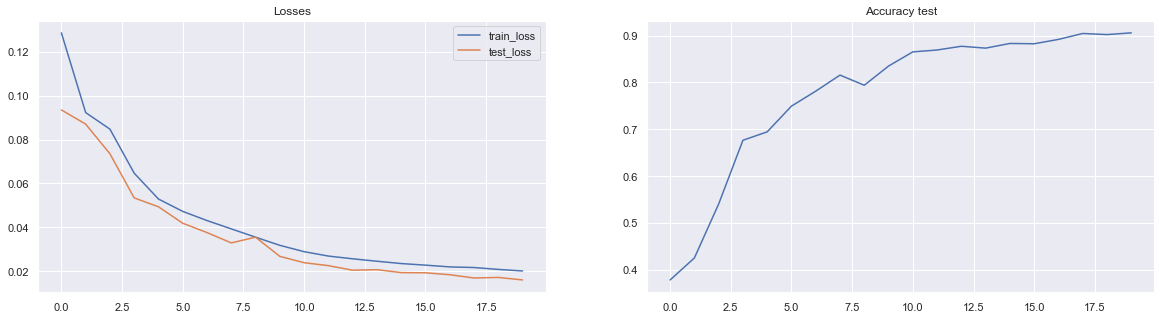

In [11]:
resultados = np.array(resultados)
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(resultados[:,0], resultados[:,1], label='train_loss')
plt.plot(resultados[:,0], resultados[:,2], label='test_loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(resultados[:,0], resultados[:, 3])
plt.title('Accuracy test')

plt.show()

# Matriz de Confusão

100%|██████████| 188/188 [00:07<00:00, 26.19it/s]


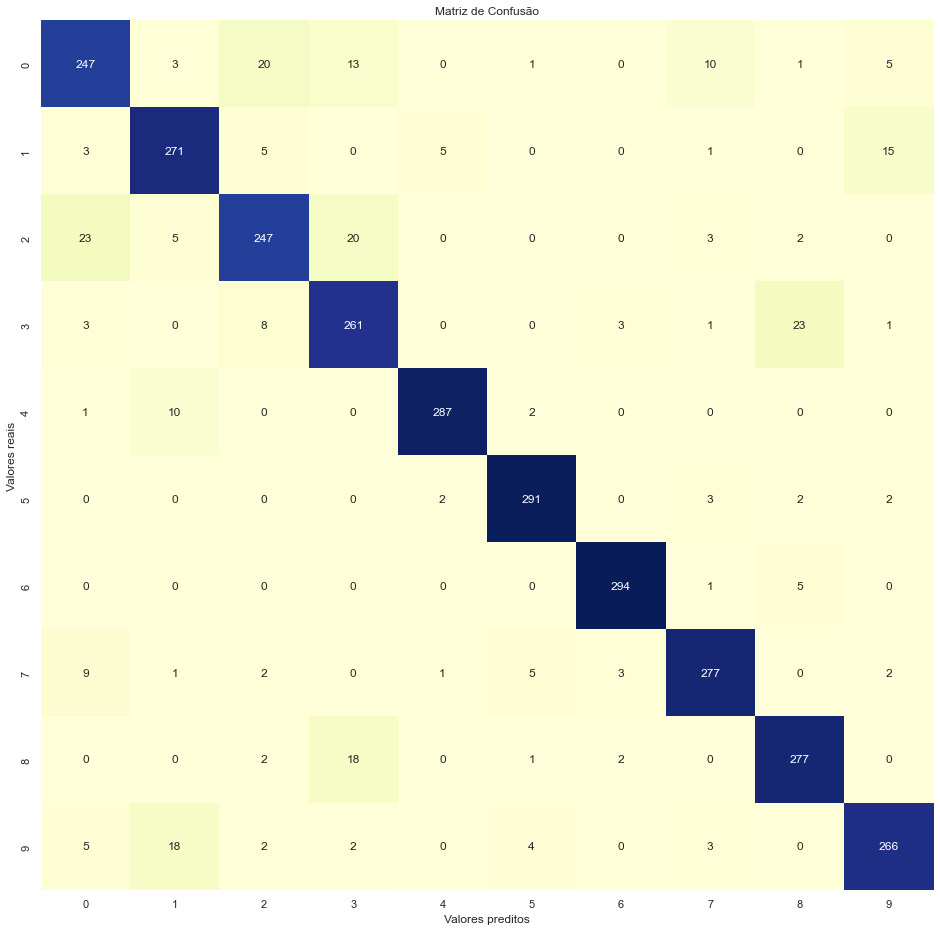

In [12]:
ytrues, ypreds = [], []
model.eval()
with torch.no_grad():
    for x, ytrue in tqdm(test_dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        ypred = model(x)

        ytrues.append(ytrue.detach().cpu().numpy())
        max_probs, indices_max = ypred.max(dim=1)
        ypreds.append(indices_max.detach().cpu().numpy())
    
ypreds = np.hstack(ypreds)
ytrues = np.hstack(ytrues)

plt.figure(figsize=(16, 16))
plt.title('Matriz de Confusão')
sns.heatmap(confusion_matrix(ytrues, ypreds), annot=True, cbar=False, fmt='0', cmap='YlGnBu')
plt.xlabel('Valores preditos')
plt.ylabel('Valores reais')
plt.show()

In [13]:
print (classification_report(ytrues, ypreds))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       300
           1       0.88      0.90      0.89       300
           2       0.86      0.82      0.84       300
           3       0.83      0.87      0.85       300
           4       0.97      0.96      0.96       300
           5       0.96      0.97      0.96       300
           6       0.97      0.98      0.98       300
           7       0.93      0.92      0.92       300
           8       0.89      0.92      0.91       300
           9       0.91      0.89      0.90       300

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

